# ECCITE 1D Analysis

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import itertools
from pybedtools import BedTool
import os
import pickle as pkl
%matplotlib inline

In [2]:
pd.set_option('max_columns', None)

In [3]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento

In [4]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

In [5]:
data_path = '/data_volume/memento/eccite/'

### Read the guide labled perturb-seq data

From perturbseq paper

In [6]:
adata = sc.read(data_path + 'eccite.h5ad')
adata.var.index.name=None

In [7]:
# guides = adata.obs.guides.drop_duplicates().tolist()
# guides = [g for g in guides if ('INTER' not in g and 'nan' not in g)]
# ko_genes = adata.obs.query('KO == 1')['KO_GENE'].drop_duplicates().tolist()

### Setup memento

In [8]:
adata.obs['q'] = 0.15

In [9]:
memento.setup_memento(adata, q_column='q', filter_mean_thresh=0.07)

Version 0.0.6


/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:70: RankWarning: Polyfit may be poorly conditioned


In [10]:
ko_genes = adata.obs.gene.drop_duplicates().tolist()

### HBEC

In [11]:
adata_hbec = sc.read('/data_volume/memento/hbec/binary_test_latest/C_gamma_3.h5ad')

In [12]:
hbec_ht = memento.get_1d_ht_result(adata_hbec)
hbec_ht['dv_fdr'] = memento.util._fdrcorrect(hbec_ht['dv_pval'])
hbec_ht['de_fdr'] = memento.util._fdrcorrect(hbec_ht['de_pval'])

Text(0.5, 1.0, 'Effect of IFN$\\gamma$ (WT ctrl -> WT stim)')

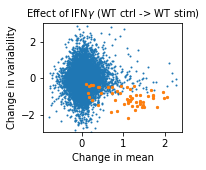

In [14]:
plt.figure(figsize=(2.5,2))

plt.scatter(hbec_ht['de_coef'], hbec_ht['dv_coef'], s=1)
plt.scatter(
    hbec_ht.query('dv_fdr < 0.1 & dv_coef < 0 & de_coef > 0 & de_fdr < 0.05')['de_coef'], 
    hbec_ht.query('dv_fdr < 0.1 & dv_coef < 0 & de_coef > 0 & de_fdr < 0.05')['dv_coef'], s=5)
plt.ylim(-2.9, 3)
plt.xlabel('Change in mean'); plt.ylabel('Change in variability')
plt.title(r'Effect of IFN$\gamma$ (WT ctrl -> WT stim)')
# plt.savefig('figures/C_gamma_3hr_1d.png'.format(tf), bbox_inches='tight', dpi=800)

### ECCITE

In [15]:
results = {}
for g in ko_genes:
#     print(g)
    if g == 'NT': continue
    subset = sc.read(data_path +'1d/{}_guides_rep.h5ad'.format(g))
    df = memento.get_1d_ht_result(subset)
    df['de_fdr'] = memento.util._fdrcorrect(df['de_pval'])
    df['dv_fdr'] = memento.util._fdrcorrect(df['dv_pval'])
    results[g] = df.copy()

In [ ]:
# for g in ko_genes:
#     print(g, results[g].query('de_fdr < 0.1').shape[0],results[g].query('dv_fdr < 0.1').shape[0])

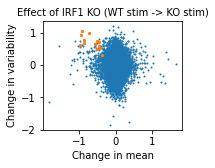

In [172]:
tf = 'IRF1'
plt.figure(figsize=(2.5,2))
plt.scatter(results[tf]['de_coef'], results[tf]['dv_coef'], s=1)
plt.title('Effect of {} KO (WT stim -> KO stim)'.format(tf));
plt.xlabel('Change in mean'); plt.ylabel('Change in variability')
plt.scatter(results[tf].query('dv_fdr < 0.1 & dv_coef > 0')['de_coef'], results[tf].query('dv_fdr < 0.1 & dv_coef > 0')['dv_coef'], s=5)
# plt.scatter(results[tf].query('dv_fdr < 0.1 & dv_coef < 0')['de_coef'], results[tf].query('dv_fdr < 0.1 & dv_coef < 0')['dv_coef'], s=5)

plt.savefig('figures/variability_{}.png'.format(tf), bbox_inches='tight', dpi=800)

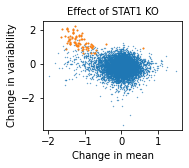

In [16]:
plt.figure(figsize=(2.5,2))
plt.scatter(results['STAT1']['de_coef'], results['STAT1']['dv_coef'], s=0.1)
plt.title('Effect of STAT1 KO');
plt.xlabel('Change in mean'); plt.ylabel('Change in variability')
plt.scatter(results['STAT1'].query('dv_fdr < 0.1 & dv_coef > 0')['de_coef'], results['STAT1'].query('dv_fdr < 0.1 & dv_coef > 0')['dv_coef'], s=1)
# plt.savefig('figures/variability.png', bbox_inches='tight', dpi=800)

### Comparison

In [16]:
results.keys()

dict_keys(['STAT2', 'CAV1', 'STAT1', 'CD86', 'IRF7', 'ATF2', 'STAT3', 'JAK2', 'NFKBIA', 'SMAD4', 'STAT5A', 'CMTM6', 'IFNGR1', 'UBE2L6', 'PDCD1LG2', 'CUL3', 'BRD4', 'MARCH8', 'IRF1', 'POU2F2', 'ETV7', 'IFNGR2', 'TNFRSF14', 'SPI1', 'MYC'])

In [17]:
isgs = hbec_ht.query('dv_fdr < 0.1 & dv_coef < 0 & de_coef > 0 & de_fdr < 0.05').gene.tolist()
isgs = hbec_ht.query('de_coef > 0 & de_fdr < 0.05').gene.tolist()

In [18]:
merged = hbec_ht.merge(results['STAT1'], on='gene', suffixes=('_stim', '_ko')).query('gene in @isgs')

In [19]:
stats.pearsonr(merged['dv_coef_stim'], merged['dv_coef_ko'])

(-0.2003800254222431, 4.7569473477500374e-08)

In [20]:
stats.pearsonr(merged['de_coef_stim'], merged['de_coef_ko'])

(-0.6138817577049791, 8.1877073251415e-77)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


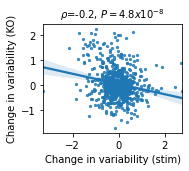

In [23]:
plt.figure(figsize=(2.5,2))

sns.regplot(merged['dv_coef_stim'], merged['dv_coef_ko'], scatter_kws={'s':5})
plt.xlabel('Change in variability (stim)'); plt.ylabel('Change in variability (KO)')
plt.title(r'$\rho$=-0.2, $P = 4.8x10^{-8}$')
plt.savefig('figures/v_es_comparison.png', bbox_inches='tight', dpi=800)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


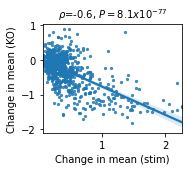

In [24]:
plt.figure(figsize=(2.5,2))

sns.regplot(merged['de_coef_stim'], merged['de_coef_ko'], scatter_kws={'s':5})
plt.xlabel('Change in mean (stim)'); plt.ylabel('Change in mean (KO)')
plt.title(r'$\rho$=-0.6, $P = 8.1x10^{-77}$')
plt.savefig('figures/m_es_comparison.png', bbox_inches='tight', dpi=800)

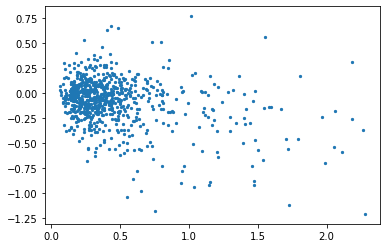

In [168]:
plt.scatter(merged['de_coef_stim'], merged['de_coef_ko'], s=5)

### Run coexpression

In [17]:
# subset_ko_genes = ['STAT1', 'STAT2', 'JAK2', 'CUL3', 'IFNGR1', 'IFNGR2', 'MYC', 'SMAD4']
done_files = os.listdir(data_path + '/2d/')
for g in ko_genes:
    
    for g_ko in ko_genes:
        print(g, g_ko)
        
        if g == g_ko or g == 'NT' or g_ko == 'NT': continue
        fname = '{}_with_{}_KO.h5ad'.format(g, g_ko)
#         if fname in done_files: continue
        
        subset = adata.copy().copy()

        subset = adata[adata.obs['gene'].isin(['NT', g_ko])].copy().copy()
    
        subset.obs['is_ko'] = subset.obs.guide_ID.str.contains(g_ko).values

        memento.create_groups(subset, label_columns=['is_ko', 'replicate', 'guide_ID'])

        memento.compute_1d_moments(subset, min_perc_group=.7)
        
        if g not in subset.var.index: continue

        available_genes = list(
            set(subset.var.index) & \
            set(results[g].query('de_coef < 0 & de_fdr < 0.1').gene.tolist()) & \
            set(results[g_ko].query('de_coef < 0 & de_fdr < 0.1').gene.tolist())
            )
        
        if len(available_genes) < 10: continue
        memento.compute_2d_moments(subset, list(itertools.product([g], available_genes))   )

        memento.ht_2d_moments( 
            subset, 
            formula_like='1 + is_ko + replicate',
            treatment_col='is_ko', 
            num_boot=10000, 
            verbose=1,
            num_cpus=94,
            resampling='bootstrap',
            approx=False)
        
        subset.write(data_path + '2d/{}_with_{}_KO_guide_rep.h5ad'.format(g, g_ko))

STAT2 STAT2
STAT2 CAV1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


STAT2 STAT1


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done 112 out of 149 | elapsed:   13.6s remaining:    4.5s
[Parallel(n_jobs=94)]: Done 149 out of 149 | elapsed:   14.9s finished
... storing 'memento_group' as categorical


STAT2 CD86


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


STAT2 IRF7
STAT2 NT
STAT2 ATF2
STAT2 STAT3
STAT2 JAK2


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  58 out of 122 | elapsed:    5.8s remaining:    6.4s
[Parallel(n_jobs=94)]: Done 122 out of 122 | elapsed:    8.6s finished
... storing 'memento_group' as categorical


STAT2 NFKBIA


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


STAT2 SMAD4


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  19 out of  68 | elapsed:    3.5s remaining:    9.0s
[Parallel(n_jobs=94)]: Done  68 out of  68 | elapsed:    4.5s finished
... storing 'memento_group' as categorical


STAT2 STAT5A


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


STAT2 CMTM6
STAT2 IFNGR1


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  62 out of 124 | elapsed:    6.5s remaining:    6.5s
[Parallel(n_jobs=94)]: Done 124 out of 124 | elapsed:    9.6s finished
... storing 'memento_group' as categorical


STAT2 UBE2L6


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


STAT2 PDCD1LG2
STAT2 CUL3
STAT2 BRD4


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 out of  19 | elapsed:    2.1s remaining:    1.2s
[Parallel(n_jobs=94)]: Done  19 out of  19 | elapsed:    2.5s finished
... storing 'memento_group' as categorical


STAT2 MARCH8


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


STAT2 IRF1


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  10 out of  65 | elapsed:    3.1s remaining:   17.2s
[Parallel(n_jobs=94)]: Done  65 out of  65 | elapsed:    5.0s finished
... storing 'memento_group' as categorical


STAT2 POU2F2


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


STAT2 ETV7
STAT2 IFNGR2


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  54 out of 120 | elapsed:    5.8s remaining:    7.1s
[Parallel(n_jobs=94)]: Done 120 out of 120 | elapsed:    9.0s finished
... storing 'memento_group' as categorical


STAT2 TNFRSF14


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


STAT2 SPI1
STAT2 MYC
CAV1 STAT2
CAV1 CAV1
CAV1 STAT1
CAV1 CD86
CAV1 IRF7
CAV1 NT
CAV1 ATF2
CAV1 STAT3
CAV1 JAK2
CAV1 NFKBIA
CAV1 SMAD4
CAV1 STAT5A
CAV1 CMTM6
CAV1 IFNGR1
CAV1 UBE2L6
CAV1 PDCD1LG2
CAV1 CUL3
CAV1 BRD4
CAV1 MARCH8
CAV1 IRF1
CAV1 POU2F2
CAV1 ETV7
CAV1 IFNGR2
CAV1 TNFRSF14
CAV1 SPI1
CAV1 MYC
STAT1 STAT2


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done 112 out of 149 | elapsed:   10.5s remaining:    3.5s
[Parallel(n_jobs=94)]: Done 149 out of 149 | elapsed:   11.5s finished
... storing 'memento_group' as categorical


STAT1 CAV1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


STAT1 STAT1
STAT1 CD86
STAT1 IRF7
STAT1 NT
STAT1 ATF2
STAT1 STAT3
STAT1 JAK2


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    6.4s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:   22.2s
[Parallel(n_jobs=94)]: Done 612 tasks      | elapsed:   49.8s
[Parallel(n_jobs=94)]: Done 1062 tasks      | elapsed:  1.4min
[Parallel(n_jobs=94)]: Done 1402 out of 1402 | elapsed:  1.8min finished
... storing 'memento_group' as categorical


STAT1 NFKBIA


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


STAT1 SMAD4


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    5.7s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:   20.7s
[Parallel(n_jobs=94)]: Done 676 out of 676 | elapsed:   49.0s finished
... storing 'memento_group' as categorical


STAT1 STAT5A


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


STAT1 CMTM6
STAT1 IFNGR1


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    6.8s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:   24.0s
[Parallel(n_jobs=94)]: Done 612 tasks      | elapsed:   54.0s
[Parallel(n_jobs=94)]: Done 1062 tasks      | elapsed:  1.5min
[Parallel(n_jobs=94)]: Done 1410 out of 1410 | elapsed:  1.9min finished
... storing 'memento_group' as categorical


STAT1 UBE2L6


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


STAT1 PDCD1LG2
STAT1 CUL3


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  30 out of  30 | elapsed:    2.9s finished
... storing 'memento_group' as categorical


STAT1 BRD4


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    4.9s
[Parallel(n_jobs=94)]: Done 202 out of 202 | elapsed:   14.2s finished
... storing 'memento_group' as categorical


STAT1 MARCH8


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


STAT1 IRF1


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    6.8s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:   23.3s
[Parallel(n_jobs=94)]: Done 570 out of 570 | elapsed:   46.2s finished
... storing 'memento_group' as categorical


STAT1 POU2F2


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


STAT1 ETV7
STAT1 IFNGR2


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    6.7s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:   22.9s
[Parallel(n_jobs=94)]: Done 612 tasks      | elapsed:   51.6s
[Parallel(n_jobs=94)]: Done 1062 tasks      | elapsed:  1.5min
[Parallel(n_jobs=94)]: Done 1396 out of 1396 | elapsed:  1.8min finished
... storing 'memento_group' as categorical


STAT1 TNFRSF14


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


STAT1 SPI1


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done   7 out of  14 | elapsed:    2.2s remaining:    2.2s
[Parallel(n_jobs=94)]: Done  14 out of  14 | elapsed:    3.0s finished
... storing 'memento_group' as categorical


STAT1 MYC


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  22 out of  29 | elapsed:    2.5s remaining:    0.8s
[Parallel(n_jobs=94)]: Done  29 out of  29 | elapsed:    2.9s finished
... storing 'memento_group' as categorical


CD86 STAT2


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


CD86 CAV1
CD86 STAT1
CD86 CD86
CD86 IRF7
CD86 NT
CD86 ATF2
CD86 STAT3
CD86 JAK2
CD86 NFKBIA
CD86 SMAD4
CD86 STAT5A
CD86 CMTM6
CD86 IFNGR1
CD86 UBE2L6
CD86 PDCD1LG2
CD86 CUL3
CD86 BRD4
CD86 MARCH8
CD86 IRF1
CD86 POU2F2
CD86 ETV7
CD86 IFNGR2
CD86 TNFRSF14
CD86 SPI1
CD86 MYC
IRF7 STAT2
IRF7 CAV1
IRF7 STAT1
IRF7 CD86
IRF7 IRF7
IRF7 NT
IRF7 ATF2
IRF7 STAT3
IRF7 JAK2
IRF7 NFKBIA
IRF7 SMAD4
IRF7 STAT5A
IRF7 CMTM6
IRF7 IFNGR1
IRF7 UBE2L6
IRF7 PDCD1LG2
IRF7 CUL3
IRF7 BRD4
IRF7 MARCH8
IRF7 IRF1
IRF7 POU2F2
IRF7 ETV7
IRF7 IFNGR2
IRF7 TNFRSF14
IRF7 SPI1
IRF7 MYC
NT STAT2
NT CAV1
NT STAT1
NT CD86
NT IRF7
NT NT
NT ATF2
NT STAT3
NT JAK2
NT NFKBIA
NT SMAD4
NT STAT5A
NT CMTM6
NT IFNGR1
NT UBE2L6
NT PDCD1LG2
NT CUL3
NT BRD4
NT MARCH8
NT IRF1
NT POU2F2
NT ETV7
NT IFNGR2
NT TNFRSF14
NT SPI1
NT MYC
ATF2 STAT2
ATF2 CAV1
ATF2 STAT1
ATF2 CD86
ATF2 IRF7
ATF2 NT
ATF2 ATF2
ATF2 STAT3
ATF2 JAK2
ATF2 NFKBIA
ATF2 SMAD4
ATF2 STAT5A
ATF2 CMTM6
ATF2 IFNGR1
ATF2 UBE2L6
ATF2 PDCD1LG2
ATF2 CUL3
ATF2 BRD4
ATF2 MARCH8
ATF2

[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  60 out of 123 | elapsed:    6.2s remaining:    6.5s
[Parallel(n_jobs=94)]: Done 123 out of 123 | elapsed:    8.8s finished
... storing 'memento_group' as categorical


JAK2 CAV1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


JAK2 STAT1


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    4.0s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:   15.3s
[Parallel(n_jobs=94)]: Done 612 tasks      | elapsed:   33.9s
[Parallel(n_jobs=94)]: Done 1062 tasks      | elapsed:   57.2s
[Parallel(n_jobs=94)]: Done 1402 out of 1402 | elapsed:  1.2min finished
... storing 'memento_group' as categorical


JAK2 CD86


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


JAK2 IRF7
JAK2 NT
JAK2 ATF2
JAK2 STAT3
JAK2 JAK2
JAK2 NFKBIA
JAK2 SMAD4


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    4.3s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:   17.8s
[Parallel(n_jobs=94)]: Done 612 tasks      | elapsed:   39.3s
[Parallel(n_jobs=94)]: Done 824 out of 824 | elapsed:   49.9s finished
... storing 'memento_group' as categorical


JAK2 STAT5A


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


JAK2 CMTM6
JAK2 IFNGR1


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    5.0s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:   18.9s
[Parallel(n_jobs=94)]: Done 612 tasks      | elapsed:   41.6s
[Parallel(n_jobs=94)]: Done 1062 tasks      | elapsed:  1.2min
[Parallel(n_jobs=94)]: Done 1612 tasks      | elapsed:  1.8min
[Parallel(n_jobs=94)]: Done 1855 out of 1855 | elapsed:  2.0min finished
... storing 'memento_group' as categorical


JAK2 UBE2L6


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


JAK2 PDCD1LG2
JAK2 CUL3


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  10 out of  32 | elapsed:    2.3s remaining:    5.2s
[Parallel(n_jobs=94)]: Done  32 out of  32 | elapsed:    2.9s finished
... storing 'memento_group' as categorical


JAK2 BRD4


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    3.9s
[Parallel(n_jobs=94)]: Done 278 out of 278 | elapsed:   16.1s finished
... storing 'memento_group' as categorical


JAK2 MARCH8


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


JAK2 IRF1


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    4.9s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:   19.6s
[Parallel(n_jobs=94)]: Done 663 out of 663 | elapsed:   43.2s finished
... storing 'memento_group' as categorical


JAK2 POU2F2


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


JAK2 ETV7
JAK2 IFNGR2


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    4.7s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:   18.3s
[Parallel(n_jobs=94)]: Done 612 tasks      | elapsed:   40.3s
[Parallel(n_jobs=94)]: Done 1062 tasks      | elapsed:  1.1min
[Parallel(n_jobs=94)]: Done 1781 out of 1781 | elapsed:  1.8min finished
... storing 'memento_group' as categorical


JAK2 TNFRSF14


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


JAK2 SPI1


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  19 out of  22 | elapsed:    2.7s remaining:    0.4s
[Parallel(n_jobs=94)]: Done  22 out of  22 | elapsed:    3.0s finished
... storing 'memento_group' as categorical


JAK2 MYC


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done   2 out of  37 | elapsed:    1.8s remaining:   31.4s
[Parallel(n_jobs=94)]: Done  37 out of  37 | elapsed:    2.8s finished
... storing 'memento_group' as categorical


NFKBIA STAT2


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


NFKBIA CAV1
NFKBIA STAT1
NFKBIA CD86
NFKBIA IRF7
NFKBIA NT
NFKBIA ATF2
NFKBIA STAT3
NFKBIA JAK2
NFKBIA NFKBIA
NFKBIA SMAD4
NFKBIA STAT5A
NFKBIA CMTM6
NFKBIA IFNGR1
NFKBIA UBE2L6
NFKBIA PDCD1LG2
NFKBIA CUL3
NFKBIA BRD4
NFKBIA MARCH8
NFKBIA IRF1
NFKBIA POU2F2
NFKBIA ETV7
NFKBIA IFNGR2
NFKBIA TNFRSF14
NFKBIA SPI1
NFKBIA MYC
SMAD4 STAT2


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  22 out of  69 | elapsed:    2.5s remaining:    5.3s
[Parallel(n_jobs=94)]: Done  69 out of  69 | elapsed:    3.6s finished
... storing 'memento_group' as categorical


SMAD4 CAV1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


SMAD4 STAT1


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    2.3s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:   10.7s
[Parallel(n_jobs=94)]: Done 676 out of 676 | elapsed:   24.3s finished
... storing 'memento_group' as categorical


SMAD4 CD86


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


SMAD4 IRF7
SMAD4 NT
SMAD4 ATF2
SMAD4 STAT3
SMAD4 JAK2


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    2.5s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:   12.9s
[Parallel(n_jobs=94)]: Done 612 tasks      | elapsed:   27.9s
[Parallel(n_jobs=94)]: Done 825 out of 825 | elapsed:   36.3s finished
... storing 'memento_group' as categorical


SMAD4 NFKBIA


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


SMAD4 SMAD4
SMAD4 STAT5A
SMAD4 CMTM6
SMAD4 IFNGR1


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    2.5s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:   13.3s
[Parallel(n_jobs=94)]: Done 612 tasks      | elapsed:   29.2s
[Parallel(n_jobs=94)]: Done 900 out of 900 | elapsed:   41.4s finished
... storing 'memento_group' as categorical


SMAD4 UBE2L6


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


SMAD4 PDCD1LG2
SMAD4 CUL3


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  32 out of  43 | elapsed:    2.0s remaining:    0.7s
[Parallel(n_jobs=94)]: Done  43 out of  43 | elapsed:    2.3s finished
... storing 'memento_group' as categorical


SMAD4 BRD4


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    2.1s
[Parallel(n_jobs=94)]: Done 370 out of 370 | elapsed:   13.4s finished
... storing 'memento_group' as categorical


SMAD4 MARCH8


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


SMAD4 IRF1


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    2.9s
[Parallel(n_jobs=94)]: Done 324 out of 324 | elapsed:   15.3s finished
... storing 'memento_group' as categorical


SMAD4 POU2F2


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


SMAD4 ETV7
SMAD4 IFNGR2


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    2.4s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:   12.8s
[Parallel(n_jobs=94)]: Done 612 tasks      | elapsed:   27.2s
[Parallel(n_jobs=94)]: Done 811 out of 811 | elapsed:   34.9s finished
... storing 'memento_group' as categorical


SMAD4 TNFRSF14


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


SMAD4 SPI1
SMAD4 MYC
STAT5A STAT2
STAT5A CAV1
STAT5A STAT1
STAT5A CD86
STAT5A IRF7
STAT5A NT
STAT5A ATF2
STAT5A STAT3
STAT5A JAK2
STAT5A NFKBIA
STAT5A SMAD4
STAT5A STAT5A
STAT5A CMTM6
STAT5A IFNGR1
STAT5A UBE2L6
STAT5A PDCD1LG2
STAT5A CUL3
STAT5A BRD4
STAT5A MARCH8
STAT5A IRF1
STAT5A POU2F2
STAT5A ETV7
STAT5A IFNGR2
STAT5A TNFRSF14
STAT5A SPI1
STAT5A MYC
CMTM6 STAT2
CMTM6 CAV1
CMTM6 STAT1
CMTM6 CD86
CMTM6 IRF7
CMTM6 NT
CMTM6 ATF2
CMTM6 STAT3
CMTM6 JAK2
CMTM6 NFKBIA
CMTM6 SMAD4
CMTM6 STAT5A
CMTM6 CMTM6
CMTM6 IFNGR1
CMTM6 UBE2L6
CMTM6 PDCD1LG2
CMTM6 CUL3
CMTM6 BRD4
CMTM6 MARCH8
CMTM6 IRF1
CMTM6 POU2F2
CMTM6 ETV7
CMTM6 IFNGR2
CMTM6 TNFRSF14
CMTM6 SPI1
CMTM6 MYC
IFNGR1 STAT2


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  64 out of 125 | elapsed:    5.2s remaining:    4.9s
[Parallel(n_jobs=94)]: Done 125 out of 125 | elapsed:    7.6s finished
... storing 'memento_group' as categorical


IFNGR1 CAV1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


IFNGR1 STAT1


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    3.1s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:   13.2s
[Parallel(n_jobs=94)]: Done 612 tasks      | elapsed:   28.6s
[Parallel(n_jobs=94)]: Done 1062 tasks      | elapsed:   48.5s
[Parallel(n_jobs=94)]: Done 1411 out of 1411 | elapsed:  1.1min finished
... storing 'memento_group' as categorical


IFNGR1 CD86


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


IFNGR1 IRF7
IFNGR1 NT
IFNGR1 ATF2
IFNGR1 STAT3
IFNGR1 JAK2


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    3.8s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:   15.8s
[Parallel(n_jobs=94)]: Done 612 tasks      | elapsed:   34.4s
[Parallel(n_jobs=94)]: Done 1062 tasks      | elapsed:   59.0s
[Parallel(n_jobs=94)]: Done 1612 tasks      | elapsed:  1.5min
[Parallel(n_jobs=94)]: Done 1856 out of 1856 | elapsed:  1.7min finished
... storing 'memento_group' as categorical


IFNGR1 NFKBIA


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


IFNGR1 SMAD4


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    3.1s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:   14.7s
[Parallel(n_jobs=94)]: Done 612 tasks      | elapsed:   31.7s
[Parallel(n_jobs=94)]: Done 899 out of 899 | elapsed:   44.3s finished
... storing 'memento_group' as categorical


IFNGR1 STAT5A


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


IFNGR1 CMTM6
IFNGR1 IFNGR1
IFNGR1 UBE2L6
IFNGR1 PDCD1LG2
IFNGR1 CUL3


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done   7 out of  38 | elapsed:    1.9s remaining:    8.6s
[Parallel(n_jobs=94)]: Done  38 out of  38 | elapsed:    2.8s finished
... storing 'memento_group' as categorical


IFNGR1 BRD4


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    2.8s
[Parallel(n_jobs=94)]: Done 326 out of 326 | elapsed:   14.7s finished
... storing 'memento_group' as categorical


IFNGR1 MARCH8


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


IFNGR1 IRF1


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    4.0s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:   16.6s
[Parallel(n_jobs=94)]: Done 685 out of 685 | elapsed:   38.3s finished
... storing 'memento_group' as categorical


IFNGR1 POU2F2


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


IFNGR1 ETV7
IFNGR1 IFNGR2


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    3.9s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:   15.8s
[Parallel(n_jobs=94)]: Done 612 tasks      | elapsed:   34.9s
[Parallel(n_jobs=94)]: Done 1062 tasks      | elapsed:   59.2s
[Parallel(n_jobs=94)]: Done 1612 tasks      | elapsed:  1.5min
[Parallel(n_jobs=94)]: Done 1807 out of 1807 | elapsed:  1.6min finished
... storing 'memento_group' as categorical


IFNGR1 TNFRSF14


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


IFNGR1 SPI1


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  10 out of  21 | elapsed:    1.8s remaining:    2.0s
[Parallel(n_jobs=94)]: Done  21 out of  21 | elapsed:    2.5s finished
... storing 'memento_group' as categorical


IFNGR1 MYC


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done   2 out of  37 | elapsed:    1.4s remaining:   24.0s
[Parallel(n_jobs=94)]: Done  37 out of  37 | elapsed:    2.6s finished
... storing 'memento_group' as categorical


UBE2L6 STAT2


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


UBE2L6 CAV1
UBE2L6 STAT1
UBE2L6 CD86
UBE2L6 IRF7
UBE2L6 NT
UBE2L6 ATF2
UBE2L6 STAT3
UBE2L6 JAK2
UBE2L6 NFKBIA
UBE2L6 SMAD4
UBE2L6 STAT5A
UBE2L6 CMTM6
UBE2L6 IFNGR1
UBE2L6 UBE2L6
UBE2L6 PDCD1LG2
UBE2L6 CUL3
UBE2L6 BRD4
UBE2L6 MARCH8
UBE2L6 IRF1
UBE2L6 POU2F2
UBE2L6 ETV7
UBE2L6 IFNGR2
UBE2L6 TNFRSF14
UBE2L6 SPI1
UBE2L6 MYC
PDCD1LG2 STAT2
PDCD1LG2 CAV1
PDCD1LG2 STAT1
PDCD1LG2 CD86
PDCD1LG2 IRF7
PDCD1LG2 NT
PDCD1LG2 ATF2
PDCD1LG2 STAT3
PDCD1LG2 JAK2
PDCD1LG2 NFKBIA
PDCD1LG2 SMAD4
PDCD1LG2 STAT5A
PDCD1LG2 CMTM6
PDCD1LG2 IFNGR1
PDCD1LG2 UBE2L6
PDCD1LG2 PDCD1LG2
PDCD1LG2 CUL3
PDCD1LG2 BRD4
PDCD1LG2 MARCH8
PDCD1LG2 IRF1
PDCD1LG2 POU2F2
PDCD1LG2 ETV7
PDCD1LG2 IFNGR2
PDCD1LG2 TNFRSF14
PDCD1LG2 SPI1
PDCD1LG2 MYC
CUL3 STAT2
CUL3 CAV1
CUL3 STAT1


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  30 out of  30 | elapsed:    2.5s finished
... storing 'memento_group' as categorical


CUL3 CD86


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


CUL3 IRF7
CUL3 NT
CUL3 ATF2
CUL3 STAT3
CUL3 JAK2


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  10 out of  32 | elapsed:    2.0s remaining:    4.4s
[Parallel(n_jobs=94)]: Done  32 out of  32 | elapsed:    3.0s finished
... storing 'memento_group' as categorical


CUL3 NFKBIA


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


CUL3 SMAD4


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  32 out of  43 | elapsed:    2.4s remaining:    0.8s
[Parallel(n_jobs=94)]: Done  43 out of  43 | elapsed:    2.8s finished
... storing 'memento_group' as categorical


CUL3 STAT5A


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


CUL3 CMTM6
CUL3 IFNGR1


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done   7 out of  38 | elapsed:    2.1s remaining:    9.4s
[Parallel(n_jobs=94)]: Done  38 out of  38 | elapsed:    3.5s finished
... storing 'memento_group' as categorical


CUL3 UBE2L6


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


CUL3 PDCD1LG2
CUL3 CUL3
CUL3 BRD4


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  20 out of  51 | elapsed:    1.7s remaining:    2.6s
[Parallel(n_jobs=94)]: Done  51 out of  51 | elapsed:    2.6s finished
... storing 'memento_group' as categorical


CUL3 MARCH8


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


CUL3 IRF1


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  22 out of  34 | elapsed:    2.4s remaining:    1.3s
[Parallel(n_jobs=94)]: Done  34 out of  34 | elapsed:    3.3s finished
... storing 'memento_group' as categorical


CUL3 POU2F2


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


CUL3 ETV7
CUL3 IFNGR2


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  16 out of  33 | elapsed:    2.4s remaining:    2.5s
[Parallel(n_jobs=94)]: Done  33 out of  33 | elapsed:    3.2s finished
... storing 'memento_group' as categorical


CUL3 TNFRSF14


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


CUL3 SPI1
CUL3 MYC
BRD4 STAT2


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 out of  19 | elapsed:    2.3s remaining:    1.4s
[Parallel(n_jobs=94)]: Done  19 out of  19 | elapsed:    2.7s finished
... storing 'memento_group' as categorical


BRD4 CAV1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


BRD4 STAT1


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=94)]: Done 202 out of 202 | elapsed:   10.7s finished
... storing 'memento_group' as categorical


BRD4 CD86


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


BRD4 IRF7
BRD4 NT
BRD4 ATF2
BRD4 STAT3
BRD4 JAK2


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    4.3s
[Parallel(n_jobs=94)]: Done 278 out of 278 | elapsed:   17.2s finished
... storing 'memento_group' as categorical


BRD4 NFKBIA


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


BRD4 SMAD4


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    3.7s
[Parallel(n_jobs=94)]: Done 370 out of 370 | elapsed:   19.9s finished
... storing 'memento_group' as categorical


BRD4 STAT5A


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


BRD4 CMTM6
BRD4 IFNGR1


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    4.1s
[Parallel(n_jobs=94)]: Done 327 out of 327 | elapsed:   21.0s finished
... storing 'memento_group' as categorical


BRD4 UBE2L6


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


BRD4 PDCD1LG2
BRD4 CUL3


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  20 out of  51 | elapsed:    2.2s remaining:    3.5s
[Parallel(n_jobs=94)]: Done  51 out of  51 | elapsed:    3.2s finished
... storing 'memento_group' as categorical


BRD4 BRD4
BRD4 MARCH8


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


BRD4 IRF1


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  88 out of 137 | elapsed:    6.8s remaining:    3.8s
[Parallel(n_jobs=94)]: Done 137 out of 137 | elapsed:    9.3s finished
... storing 'memento_group' as categorical


BRD4 POU2F2


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


BRD4 ETV7
BRD4 IFNGR2


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    4.3s
[Parallel(n_jobs=94)]: Done 269 out of 269 | elapsed:   17.2s finished
... storing 'memento_group' as categorical


BRD4 TNFRSF14


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


BRD4 SPI1


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  10 out of  10 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=94)]: Done  10 out of  10 | elapsed:    2.5s finished
... storing 'memento_group' as categorical


BRD4 MYC


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  16 out of  50 | elapsed:    2.3s remaining:    4.8s
[Parallel(n_jobs=94)]: Done  50 out of  50 | elapsed:    3.0s finished
... storing 'memento_group' as categorical


MARCH8 STAT2


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


MARCH8 CAV1
MARCH8 STAT1
MARCH8 CD86
MARCH8 IRF7
MARCH8 NT
MARCH8 ATF2
MARCH8 STAT3
MARCH8 JAK2
MARCH8 NFKBIA
MARCH8 SMAD4
MARCH8 STAT5A
MARCH8 CMTM6
MARCH8 IFNGR1
MARCH8 UBE2L6
MARCH8 PDCD1LG2
MARCH8 CUL3
MARCH8 BRD4
MARCH8 MARCH8
MARCH8 IRF1
MARCH8 POU2F2
MARCH8 ETV7
MARCH8 IFNGR2
MARCH8 TNFRSF14
MARCH8 SPI1
MARCH8 MYC
IRF1 STAT2


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  13 out of  66 | elapsed:    4.1s remaining:   16.6s
[Parallel(n_jobs=94)]: Done  66 out of  66 | elapsed:    5.4s finished
... storing 'memento_group' as categorical


IRF1 CAV1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


IRF1 STAT1


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    5.1s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:   18.6s
[Parallel(n_jobs=94)]: Done 569 out of 569 | elapsed:   37.0s finished
... storing 'memento_group' as categorical


IRF1 CD86


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


IRF1 IRF7
IRF1 NT
IRF1 ATF2
IRF1 STAT3
IRF1 JAK2


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    6.2s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:   22.3s
[Parallel(n_jobs=94)]: Done 663 out of 663 | elapsed:   50.7s finished
... storing 'memento_group' as categorical


IRF1 NFKBIA


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


IRF1 SMAD4


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    6.2s
[Parallel(n_jobs=94)]: Done 323 out of 323 | elapsed:   24.5s finished
... storing 'memento_group' as categorical


IRF1 STAT5A


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


IRF1 CMTM6
IRF1 IFNGR1


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    6.5s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:   23.8s
[Parallel(n_jobs=94)]: Done 684 out of 684 | elapsed:   55.9s finished
... storing 'memento_group' as categorical


IRF1 UBE2L6


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


IRF1 PDCD1LG2
IRF1 CUL3


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  22 out of  34 | elapsed:    2.8s remaining:    1.5s
[Parallel(n_jobs=94)]: Done  34 out of  34 | elapsed:    3.0s finished
... storing 'memento_group' as categorical


IRF1 BRD4


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  88 out of 137 | elapsed:    6.8s remaining:    3.8s
[Parallel(n_jobs=94)]: Done 137 out of 137 | elapsed:    9.6s finished
... storing 'memento_group' as categorical


IRF1 MARCH8


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


IRF1 IRF1
IRF1 POU2F2
IRF1 ETV7
IRF1 IFNGR2


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    6.3s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:   22.8s
[Parallel(n_jobs=94)]: Done 676 out of 676 | elapsed:   53.2s finished
... storing 'memento_group' as categorical


IRF1 TNFRSF14


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


IRF1 SPI1


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done   7 out of  12 | elapsed:    2.3s remaining:    1.6s
[Parallel(n_jobs=94)]: Done  12 out of  12 | elapsed:    3.0s finished
... storing 'memento_group' as categorical


IRF1 MYC


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  10 out of  21 | elapsed:    2.3s remaining:    2.5s
[Parallel(n_jobs=94)]: Done  21 out of  21 | elapsed:    2.5s finished
... storing 'memento_group' as categorical


POU2F2 STAT2


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


POU2F2 CAV1
POU2F2 STAT1
POU2F2 CD86
POU2F2 IRF7
POU2F2 NT
POU2F2 ATF2
POU2F2 STAT3
POU2F2 JAK2
POU2F2 NFKBIA
POU2F2 SMAD4
POU2F2 STAT5A
POU2F2 CMTM6
POU2F2 IFNGR1
POU2F2 UBE2L6
POU2F2 PDCD1LG2
POU2F2 CUL3
POU2F2 BRD4
POU2F2 MARCH8
POU2F2 IRF1
POU2F2 POU2F2
POU2F2 ETV7
POU2F2 IFNGR2
POU2F2 TNFRSF14
POU2F2 SPI1
POU2F2 MYC
ETV7 STAT2
ETV7 CAV1
ETV7 STAT1
ETV7 CD86
ETV7 IRF7
ETV7 NT
ETV7 ATF2
ETV7 STAT3
ETV7 JAK2
ETV7 NFKBIA
ETV7 SMAD4
ETV7 STAT5A
ETV7 CMTM6
ETV7 IFNGR1
ETV7 UBE2L6
ETV7 PDCD1LG2
ETV7 CUL3
ETV7 BRD4
ETV7 MARCH8
ETV7 IRF1
ETV7 POU2F2
ETV7 ETV7
ETV7 IFNGR2
ETV7 TNFRSF14
ETV7 SPI1
ETV7 MYC
IFNGR2 STAT2


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  56 out of 121 | elapsed:    6.5s remaining:    7.6s
[Parallel(n_jobs=94)]: Done 121 out of 121 | elapsed:    9.5s finished
... storing 'memento_group' as categorical


IFNGR2 CAV1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


IFNGR2 STAT1


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    4.8s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:   17.6s
[Parallel(n_jobs=94)]: Done 612 tasks      | elapsed:   39.5s
[Parallel(n_jobs=94)]: Done 1062 tasks      | elapsed:  1.1min
[Parallel(n_jobs=94)]: Done 1397 out of 1397 | elapsed:  1.4min finished
... storing 'memento_group' as categorical


IFNGR2 CD86


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


IFNGR2 IRF7
IFNGR2 NT
IFNGR2 ATF2
IFNGR2 STAT3
IFNGR2 JAK2


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    6.1s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:   21.3s
[Parallel(n_jobs=94)]: Done 612 tasks      | elapsed:   47.8s
[Parallel(n_jobs=94)]: Done 1062 tasks      | elapsed:  1.3min
[Parallel(n_jobs=94)]: Done 1782 out of 1782 | elapsed:  2.2min finished
... storing 'memento_group' as categorical


IFNGR2 NFKBIA


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


IFNGR2 SMAD4


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    5.0s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:   19.5s
[Parallel(n_jobs=94)]: Done 612 tasks      | elapsed:   43.4s
[Parallel(n_jobs=94)]: Done 811 out of 811 | elapsed:   54.5s finished
... storing 'memento_group' as categorical


IFNGR2 STAT5A


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


IFNGR2 CMTM6
IFNGR2 IFNGR1


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    6.5s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:   22.8s
[Parallel(n_jobs=94)]: Done 612 tasks      | elapsed:   51.2s
[Parallel(n_jobs=94)]: Done 1062 tasks      | elapsed:  1.5min
[Parallel(n_jobs=94)]: Done 1612 tasks      | elapsed:  2.2min
[Parallel(n_jobs=94)]: Done 1807 out of 1807 | elapsed:  2.4min finished
... storing 'memento_group' as categorical


IFNGR2 UBE2L6


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


IFNGR2 PDCD1LG2
IFNGR2 CUL3


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  16 out of  33 | elapsed:    2.7s remaining:    2.8s
[Parallel(n_jobs=94)]: Done  33 out of  33 | elapsed:    3.1s finished
... storing 'memento_group' as categorical


IFNGR2 BRD4


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    4.6s
[Parallel(n_jobs=94)]: Done 269 out of 269 | elapsed:   16.5s finished
... storing 'memento_group' as categorical


IFNGR2 MARCH8


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


IFNGR2 IRF1


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    5.9s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:   21.6s
[Parallel(n_jobs=94)]: Done 676 out of 676 | elapsed:   50.5s finished
... storing 'memento_group' as categorical


IFNGR2 POU2F2


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


IFNGR2 ETV7
IFNGR2 IFNGR2
IFNGR2 TNFRSF14
IFNGR2 SPI1


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 out of  19 | elapsed:    2.3s remaining:    1.3s
[Parallel(n_jobs=94)]: Done  19 out of  19 | elapsed:    3.1s finished
... storing 'memento_group' as categorical


IFNGR2 MYC


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  10 out of  32 | elapsed:    2.1s remaining:    4.5s
[Parallel(n_jobs=94)]: Done  32 out of  32 | elapsed:    2.7s finished
... storing 'memento_group' as categorical


TNFRSF14 STAT2


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


TNFRSF14 CAV1
TNFRSF14 STAT1
TNFRSF14 CD86
TNFRSF14 IRF7
TNFRSF14 NT
TNFRSF14 ATF2
TNFRSF14 STAT3
TNFRSF14 JAK2
TNFRSF14 NFKBIA
TNFRSF14 SMAD4
TNFRSF14 STAT5A
TNFRSF14 CMTM6
TNFRSF14 IFNGR1
TNFRSF14 UBE2L6
TNFRSF14 PDCD1LG2
TNFRSF14 CUL3
TNFRSF14 BRD4
TNFRSF14 MARCH8
TNFRSF14 IRF1
TNFRSF14 POU2F2
TNFRSF14 ETV7
TNFRSF14 IFNGR2
TNFRSF14 TNFRSF14
TNFRSF14 SPI1
TNFRSF14 MYC
SPI1 STAT2
SPI1 CAV1
SPI1 STAT1


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done   7 out of  14 | elapsed:    2.4s remaining:    2.4s
[Parallel(n_jobs=94)]: Done  14 out of  14 | elapsed:    2.7s finished
... storing 'memento_group' as categorical


SPI1 CD86


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


SPI1 IRF7
SPI1 NT
SPI1 ATF2
SPI1 STAT3
SPI1 JAK2


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  19 out of  22 | elapsed:    3.3s remaining:    0.5s
[Parallel(n_jobs=94)]: Done  22 out of  22 | elapsed:    3.4s finished
... storing 'memento_group' as categorical


SPI1 NFKBIA


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


SPI1 SMAD4


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 out of  19 | elapsed:    2.9s remaining:    1.7s
[Parallel(n_jobs=94)]: Done  19 out of  19 | elapsed:    3.2s finished
... storing 'memento_group' as categorical


SPI1 STAT5A


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


SPI1 CMTM6
SPI1 IFNGR1


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  10 out of  21 | elapsed:    3.4s remaining:    3.7s
[Parallel(n_jobs=94)]: Done  21 out of  21 | elapsed:    3.9s finished
... storing 'memento_group' as categorical


SPI1 UBE2L6


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


SPI1 PDCD1LG2
SPI1 CUL3
SPI1 BRD4


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  10 out of  10 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=94)]: Done  10 out of  10 | elapsed:    2.5s finished
... storing 'memento_group' as categorical


SPI1 MARCH8


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


SPI1 IRF1


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done   7 out of  12 | elapsed:    3.1s remaining:    2.2s
[Parallel(n_jobs=94)]: Done  12 out of  12 | elapsed:    3.4s finished
... storing 'memento_group' as categorical


SPI1 POU2F2


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


SPI1 ETV7
SPI1 IFNGR2


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 out of  19 | elapsed:    3.3s remaining:    1.9s
[Parallel(n_jobs=94)]: Done  19 out of  19 | elapsed:    3.7s finished
... storing 'memento_group' as categorical


SPI1 TNFRSF14


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


SPI1 SPI1
SPI1 MYC
MYC STAT2
MYC CAV1
MYC STAT1


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  22 out of  29 | elapsed:    1.9s remaining:    0.6s
[Parallel(n_jobs=94)]: Done  29 out of  29 | elapsed:    2.6s finished
... storing 'memento_group' as categorical


MYC CD86


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


MYC IRF7
MYC NT
MYC ATF2
MYC STAT3
MYC JAK2


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done   2 out of  37 | elapsed:    1.9s remaining:   32.8s
[Parallel(n_jobs=94)]: Done  37 out of  37 | elapsed:    3.5s finished
... storing 'memento_group' as categorical


MYC NFKBIA


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


MYC SMAD4


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  16 out of  33 | elapsed:    1.9s remaining:    2.0s
[Parallel(n_jobs=94)]: Done  33 out of  33 | elapsed:    3.1s finished
... storing 'memento_group' as categorical


MYC STAT5A


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


MYC CMTM6
MYC IFNGR1


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done   2 out of  37 | elapsed:    1.8s remaining:   31.7s
[Parallel(n_jobs=94)]: Done  37 out of  37 | elapsed:    3.6s finished
... storing 'memento_group' as categorical


MYC UBE2L6


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


MYC PDCD1LG2
MYC CUL3
MYC BRD4


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  16 out of  50 | elapsed:    2.3s remaining:    4.8s
[Parallel(n_jobs=94)]: Done  50 out of  50 | elapsed:    3.2s finished
... storing 'memento_group' as categorical


MYC MARCH8


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


MYC IRF1


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  10 out of  21 | elapsed:    2.1s remaining:    2.3s
[Parallel(n_jobs=94)]: Done  21 out of  21 | elapsed:    3.1s finished
... storing 'memento_group' as categorical


MYC POU2F2


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


MYC ETV7
MYC IFNGR2


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  10 out of  32 | elapsed:    1.9s remaining:    4.2s
[Parallel(n_jobs=94)]: Done  32 out of  32 | elapsed:    3.4s finished
... storing 'memento_group' as categorical


MYC TNFRSF14


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


MYC SPI1
MYC MYC


In [36]:
len(available_genes)

174

In [37]:
df = memento.get_2d_ht_result(subset)

In [38]:
df['corr_fdr'] = memento.util._fdrcorrect(df['corr_pval'])

In [39]:
df.query('gene_2 == "IFI6"')

,gene_1,gene_2,corr_coef,corr_se,corr_pval,corr_fdr
96,STAT1,IFI6,0.024293,0.05177,0.641736,0.946714


In [41]:
df.sort_values('corr_coef')

,gene_1,gene_2,corr_coef,corr_se,corr_pval,corr_fdr
114,STAT1,ERAP2,-0.350157,0.134570,0.009099,0.475702
51,STAT1,DHX58,-0.293619,0.177382,0.098190,0.894958
146,STAT1,UNC93B1,-0.243140,0.084626,0.004600,0.397860
108,STAT1,NUBP1,-0.223356,0.138439,0.105789,0.915078
168,STAT1,HESX1,-0.213875,0.096049,0.024798,0.646523
...,...,...,...,...,...,...
167,STAT1,PARP12,0.169223,0.095715,0.076992,0.894958
95,STAT1,IFI35,0.187848,0.059027,0.001158,0.200381
138,STAT1,IFIT5,0.234801,0.187125,0.219978,0.926281
59,STAT1,KRT8,0.251940,0.098394,0.010999,0.475702


In [43]:
df.query('corr_fdr < 0.25')

,gene_1,gene_2,corr_coef,corr_se,corr_pval,corr_fdr
95,STAT1,IFI35,0.187848,0.059027,0.001158,0.200381


In [17]:
heatmap = pd.DataFrame(index=subset_ko_genes, columns=subset_ko_genes)

In [18]:
results_2d = {}
for g, g_ko in itertools.product(ko_genes, ko_genes):
    
    if g == g_ko: continue
    
    subset = sc.read(data_path + '2d/{}_with_{}_KO_guide_rep.h5ad'.format(g, g_ko))
    df = memento.get_2d_ht_result(subset)
    df['corr_fdr'] = memento.util._fdrcorrect(df['corr_pval'])
    results_2d[g+'-'+g_ko] = df.copy()
    
    print(g, g_ko, df.query('corr_fdr < 0.1  & corr_coef < 0').shape[0])


NameError: name 'subset_ko_genes' is not defined

In [27]:
results_2d['JAK2-STAT1'].query('corr_fdr < 0.1 & corr_coef < 0').head(50)

,gene_1,gene_2,corr_coef,corr_se,corr_pval,corr_fdr
205,JAK2,IL8,-0.249123,0.085160,0.003400,0.041425
231,JAK2,CYBA,-0.212820,0.078911,0.006399,0.064545
294,JAK2,DMXL2,-0.569310,0.147489,0.000600,0.016642
393,JAK2,MT-ND5,-0.271012,0.086340,0.001900,0.026175
429,JAK2,CPT2,-0.428563,0.169920,0.011099,0.091751
547,JAK2,GSK3B,-0.559475,0.172071,0.001500,0.022842
745,JAK2,SUMO2,-0.250239,0.097682,0.011799,0.095661
767,JAK2,DPYD,-0.304292,0.117713,0.009699,0.085357
1155,JAK2,SCAMP3,-0.303503,0.119663,0.011999,0.096910
1158,JAK2,MT-CO1,-0.292843,0.097021,0.001900,0.026175


In [26]:
results_2d['STAT1-JAK2'].query('corr_fdr < 0.1 & corr_coef < 0').head(50)

,gene_1,gene_2,corr_coef,corr_se,corr_pval,corr_fdr
173,STAT1,KANK2,-0.157967,0.059940,0.008899,0.051533
186,STAT1,MYL6,-0.116880,0.047259,0.015198,0.076839
207,STAT1,EMB,-0.158308,0.067767,0.020498,0.096187
350,STAT1,GMFG,-0.165820,0.065407,0.012199,0.065962
397,STAT1,CORO1B,-0.189396,0.071146,0.008399,0.049338
478,STAT1,TLE3,-0.183115,0.072209,0.010299,0.058195
488,STAT1,IPCEF1,-0.268291,0.077757,0.001082,0.011404
497,STAT1,MCCC2,-0.280598,0.100360,0.004000,0.027101
574,STAT1,TMEM154,-0.413352,0.111395,0.001314,0.012330
591,STAT1,GRN,-0.127577,0.049534,0.008899,0.051533


In [18]:
df = memento.get_1d_ht_result(subset)

In [19]:
df['de_fdr'] = memento.util._fdrcorrect(df['de_pval'])
df['dv_fdr'] = memento.util._fdrcorrect(df['dv_pval'])

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='de_coef', ylabel='Density'>

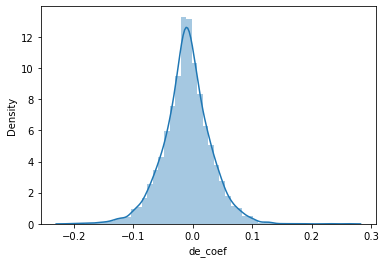

In [70]:
sns.distplot(df['de_coef'])

In [71]:
df['dv_pval'].min()

0.00027310807688639584

In [79]:
filtered_df = df.query('dv_coef > 0.6 | dv_coef < -0.6').copy()
filtered_df['de_fdr'] = memento.util._fdrcorrect(filtered_df['de_pval'])
filtered_df['dv_fdr'] = memento.util._fdrcorrect(filtered_df['dv_pval'])

In [80]:
filtered_df.sort_values('de_fdr')

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,de_fdr,dv_fdr
2590,Appl1,-0.189303,0.062989,0.002653,-1.045370,0.893075,0.241789,0.570382,0.267774
2637,Ngdn,0.066474,0.038300,0.082629,-0.619962,0.197640,0.001708,0.683281,0.082191
1008,Zdhhc21,0.098259,0.052358,0.060562,0.642448,0.372952,0.084961,0.683281,0.161127
3867,Gm5483,-0.191321,0.097545,0.049838,-1.226904,0.870802,0.158854,0.683281,0.201676
3749,Twf1,-0.067900,0.039066,0.082196,0.784043,0.227191,0.000558,0.683281,0.082191
...,...,...,...,...,...,...,...,...,...
3738,Atxn10,-0.001235,0.042985,0.977087,0.636208,0.307657,0.038648,0.984020,0.147004
2713,4931406C07Rik,-0.001389,0.053892,0.979443,0.796920,0.569918,0.162021,0.984020,0.202527
2904,Ndufaf3,0.002372,0.044915,0.957888,0.718853,0.393524,0.067744,0.984020,0.150387
261,Phyh,0.002676,0.060083,0.964480,0.724015,0.511069,0.156580,0.984020,0.201586


In [72]:
df.sort_values('dv_pval')

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,de_fdr,dv_fdr
3617,Dab2,-0.009180,0.030172,0.760938,-0.560985,0.154136,0.000273,0.982760,0.797630
3749,Twf1,-0.067900,0.039066,0.082196,0.784043,0.227191,0.000558,0.862292,0.797630
3618,Fyb,0.003404,0.032799,0.917338,0.430096,0.132779,0.001199,0.988550,0.797630
803,Ubap2l,0.032034,0.027460,0.243391,0.798079,0.248173,0.001301,0.907900,0.797630
820,S100a11,0.016178,0.012787,0.205789,0.135432,0.042790,0.001551,0.907900,0.797630
...,...,...,...,...,...,...,...,...,...
3528,Arf6,-0.033421,0.026366,0.204944,0.000226,0.147194,0.998776,0.907900,0.999479
2287,Tmbim4,0.013307,0.026034,0.609262,0.000183,0.141843,0.998969,0.966870,0.999479
370,Gca,0.150333,0.149174,0.313564,-0.000617,0.517727,0.999049,0.911683,0.999479
87,Wdfy1,-0.145767,0.048090,0.002436,-0.000196,0.209772,0.999254,0.654695,0.999479


(array([511., 503., 498., 436., 449., 420., 400., 459., 361., 404.]),
 array([2.73108077e-04, 1.00213367e-01, 2.00153626e-01, 3.00093885e-01,
        4.00034145e-01, 4.99974404e-01, 5.99914663e-01, 6.99854922e-01,
        7.99795181e-01, 8.99735440e-01, 9.99675699e-01]),
 <BarContainer object of 10 artists>)

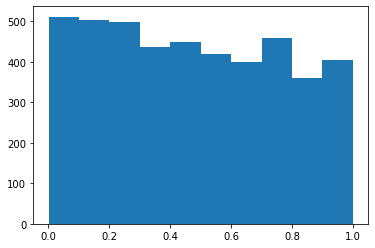

In [69]:
plt.hist(df['dv_pval'])